In [1]:
# Data Manipulation
import json
import numpy as np
import pandas as pd
import re

# Plotting
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import squarify

# Natural Language Processing
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer

# Geospatial Analysis
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

# Statistical Analysis
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Visualization
import ruptures as rpt

# External Services
import boto3

# IPython Configuration for interactive output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Get data

## Wetland Impact analysis (2020-2023)



In [2]:

# Set the working directory
os.chdir(r'D:\Work\Georgetown\acad\mdi\usace\usace_analysis\spatial')


#read
# val_df = pd.read_parquet('val_df_5jan.parquet')
# wet_df = pd.read_parquet('wet_df_5jan.parquet')
# emb_df = pd.read_parquet('emb_df_5jan.parquet')


loc_df = pd.read_parquet('loc_df_5jan.parquet')

wet_emb = pd.read_parquet('wet_loss_20_emb.parquet')

### Location table

In [3]:

#only need dist name, and lat-lon
spdf = loc_df[(loc_df.type.str.contains('latitude|longitude|districtName',na=False))]

#remove empty rows
spdf=spdf[spdf.detail.apply(len)>2]

# Drop the 'rowID' column
spdf = spdf.drop('rowID', axis=1)

# Pivot the DataFrame to wide format
spdf = spdf.pivot(index='noticeID', columns='type', values='detail')

# Resetting the index to make 'noticeID' a column again
spdf.reset_index(inplace=True)

# Function to safely evaluate strings into lists
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except ValueError:
        return []

# Apply safe_eval to convert string representations of lists into actual lists
spdf['latitude'] = spdf['latitude'].apply(safe_eval)
spdf['longitude'] = spdf['longitude'].apply(safe_eval)

# Create 'coord' column by zipping latitude and longitude
spdf['coord'] = spdf.apply(lambda row: list(zip(row['latitude'], row['longitude'])), axis=1)

# Explode 'coord' column into multiple rows if there are multiple coordinates
spdf = spdf.explode('coord')

# Reset index if needed
spdf.reset_index(drop=True, inplace=True)

# Assuming df_exploded is your exploded DataFrame with 'coord' column
# Convert coordinates to Point objects
spdf['geometry'] = spdf['coord'].apply(lambda x: Point(x[1], x[0]) if isinstance(x, (list, tuple)) and len(x) == 2 else None)


# Create a GeoDataFrame
spdf = gpd.GeoDataFrame(spdf, geometry='geometry')

spdf.geometry.dropna(inplace=True)

# Extract latitude and create a new column 'latitude'
spdf['lat'] = spdf.geometry.y

spdf['lon'] = spdf.geometry.x

#set CRS
spdf.crs='epsg:4326'

# merge with 2020-2024 wetland+embedding data
spdf=spdf.merge(wet_emb, on='noticeID', how='left')

# column to denote confirmed wetland losss 
spdf['wetland_loss_20'] = spdf['noticeID'].isin(wet_emb.noticeID).astype(int)


In [7]:
# confirmed wetland losses
spdf.wetland_loss_20.value_counts()

wetland_loss_20
0    7272
1    1040
Name: count, dtype: int64

In [24]:
spdf.shape

(8312, 30)



## 2. Boundaries

Read in shapefiles of the boundary polygons required:

- USACE districts

- US States




### 1.1 USACE shapefile

In [8]:
usace_shp = gpd.read_file('USACE_Regulatory_Boundary.zip', crs='epsg:4326')

usace_shp = usace_shp[(usace_shp.DISTRICT.isin(['Jacksonville', 'Galveston', 
                                                'New Orleans', 'Mobile']))]

usace_shp = usace_shp.set_crs(epsg=4326)



### 1.2 States

Limit the analysis to the mainland for now.

In [10]:
#subset to mainland
state_url = 'https://www2.census.gov/geo/tiger/TIGER2022/STATE/tl_2022_us_state.zip'

st_shp = gpd.read_file(state_url)


states = ['West Virginia', 'Florida', 'Illinois', 'Minnesota', 'Maryland',
          'Rhode Island', 'Idaho', 'New Hampshire', 'North Carolina',
          'Vermont', 'Connecticut', 'Delaware', 'New Mexico', 'California',
          'New Jersey', 'Wisconsin', 'Oregon', 'Nebraska', 'Pennsylvania',
          'Washington', 'Louisiana', 'Georgia', 'Alabama', 'Utah', 'Ohio',
          'Texas', 'Colorado', 'South Carolina', 'Oklahoma', 'Tennessee',
          'Wyoming', 'Hawaii', 'North Dakota', 'Kentucky',
          'United States Virgin Islands',
          'Commonwealth of the Northern Mariana Islands', 'Guam', 'Maine',
          'New York', 'Nevada', 'Alaska', 'American Samoa', 'Michigan',
          'Arkansas', 'Mississippi', 'Missouri', 'Montana', 'Kansas',
          'Indiana', 'Puerto Rico', 'South Dakota', 'Massachusetts',
          'Virginia', 'District of Columbia', 'Iowa', 'Arizona']

# Territories and non-mainland states to be removed
non_mainland = ['Hawaii', 'Alaska', 'United States Virgin Islands',
                'Commonwealth of the Northern Mariana Islands', 'Guam', 'Puerto Rico',
                'American Samoa', ] #'District of Columbia'

# Filter to mainland states + PR
req_states = [state for state in states if state not in non_mainland]

st_shp = st_shp[st_shp.NAME.isin(req_states)]



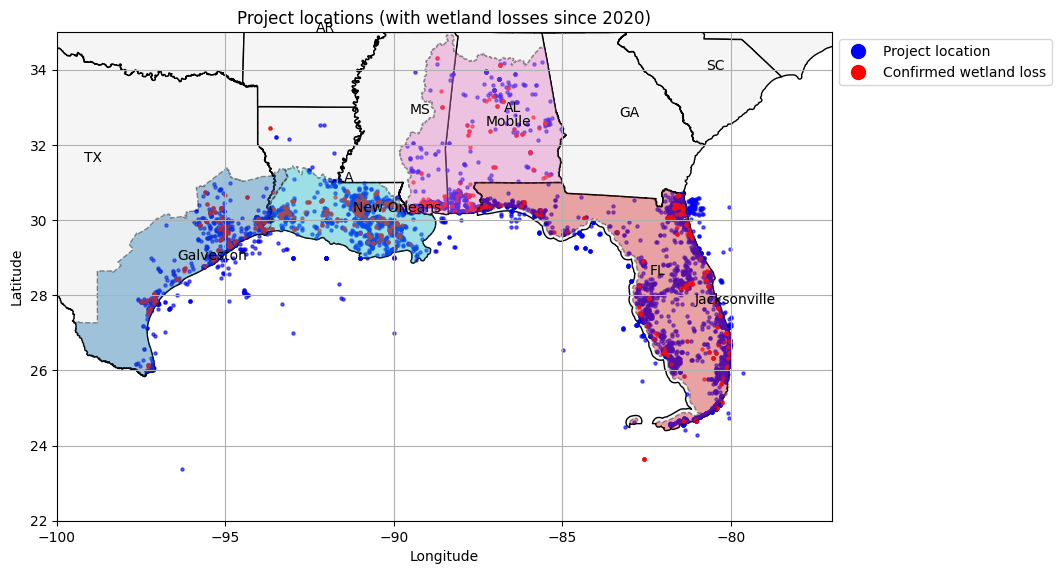

In [131]:


# Assuming st_shp, spdf, and usace_shp are GeoDataFrames you have defined

fig, ax = plt.subplots(figsize=(10,10))

# Overlay plot
st_shp.plot(color='whitesmoke', ax=ax, edgecolor='black')

# Plot points based on 'wetland_loss_20' value
colors = {0: 'blue', 1: 'red'}
for value, color in colors.items():
    spdf[spdf['wetland_loss_20'] == value].plot(marker='o', color=color, markersize=5, alpha=0.6, ax=ax, label=str(value))

usace_shp.plot(column='DISTRICT', ax=ax, alpha=0.4, edgecolor='black', linestyle='--')

# Set the x-axis and y-axis limits
ax.set_xlim(left=-100, right=-77)
ax.set_ylim(top=35, bottom=22)  

# Annotate States from st_shp
for idx, row in st_shp.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(text=row['STUSPS'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points", color='black')

# Annotate USACE Districts from usace_shp
for idx, row in usace_shp.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(text=row['DISTRICT'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Customize the plot
plt.title("Project locations (with wetland losses since 2020)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)


# Create custom legend
legend_elements = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Project location'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Confirmed wetland loss')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show();


## Get demographic data and maps 


### 2. CEJST (Geography - Tract) + Join with USACE district

This dataset is hosted on EIDC Redivis here: https://redivis.com/EIDC/admin/datasets/jf53-3sapx6pmv

In [78]:
# url  https://redivis.com/EIDC/admin/datasets/jf53-3sapx6pmv
cejst = pd.read_csv(r'CEJST_communities_list_shapefile.csv', low_memory=False)
#subset to states
cj = cejst[cejst.SF.isin(['Texas', 'Louisiana', 'Florida', 'Alabama', 'Mississippi'])]
#export to parquet
cj.to_parquet('cejst_tracts.parquet')


In [81]:
#read in parquet
# cj = pd.read_parquet('cejst_tracts.parquet')

cj['geom_tract'] = cj['geometry'].apply(wkt.loads)

cj = gpd.GeoDataFrame(cj, crs='epsg:4326', geometry=cj['geom_tract'])

cj['DA_score'] = cj['CC']

cj['is_disadv'] = cj['DA_score']>0

C:\Users\HK\AppData\Local\Temp\ipykernel_14572\4008381137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cj['geom_tract'] = cj['geometry'].apply(wkt.loads)


### Calculate the share of tracts with DA_Score>0 in each USACE district.

In [82]:
# set CRS and spatial join
cj.crs= 'epsg:4326'
usace_shp.crs= 'epsg:4326'
# Check if 'index_right' is in the DataFrame
if 'index_right' in cj.columns:
    # If the column exists, drop it
    cj = cj.drop('index_right', axis=1)

us_cj = usace_shp.sjoin(cj, predicate='intersects', how='left')    

# the CC variable records the number of categories of disadvantage for the tract    
# Filter rows where CC > 0
df_filtered = us_cj[us_cj['CC'] > 0]

# Group by 'DISTRICT' and count the number of rows with CC > 0
grouped_filtered = df_filtered.groupby('DISTRICT').size()

# Group by 'DISTRICT' and count the total number of rows
grouped_total = us_cj.groupby('DISTRICT').size()

# Calculate the share for each district
share = grouped_filtered / grouped_total

# Creating a DataFrame for the result
result_df = share.reset_index(name='Share of Rows with CC > 0')

print(result_df)

       DISTRICT  Share of Rows with CC > 0
0     Galveston                   0.508074
1  Jacksonville                   0.350211
2        Mobile                   0.513389
3   New Orleans                   0.464245


### The above table shows the share of tracts classified as disadvantaged in each USACE district.

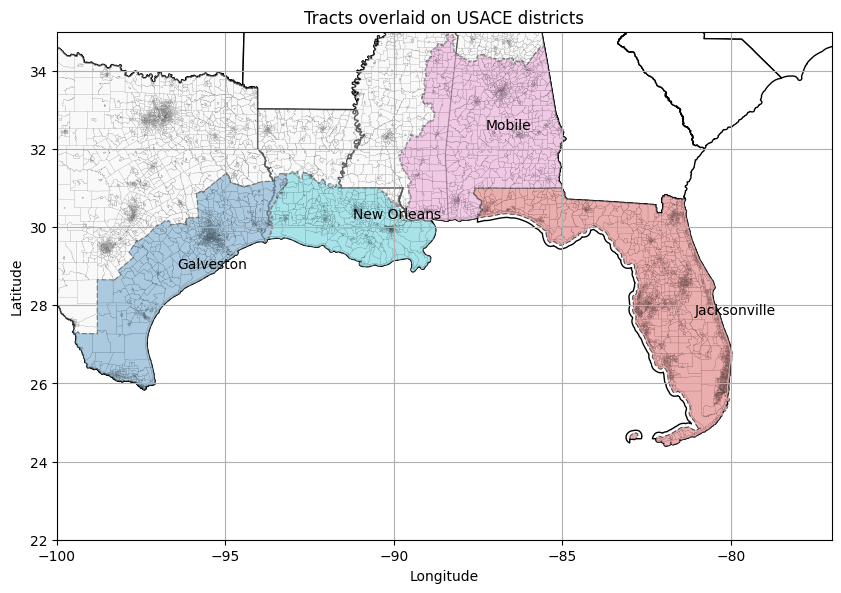

In [132]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Assuming st_shp, usace_shp, and cj are correctly prepared GeoDataFrames

fig, ax = plt.subplots(figsize=(10, 10))

# Overlay plot
st_shp.plot(color='white', ax=ax, edgecolor='black')
usace_shp.plot(column='DISTRICT', ax=ax, alpha=0.7, edgecolor='black', linestyle='--')
cj.plot(alpha=0.5, ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.1)

# Annotate USACE Districts from usace_shp
for idx, row in usace_shp.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(text=row['DISTRICT'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points", color='black', fontsize=10)

# Set the x-axis and y-axis limits
ax.set_xlim(left=-100, right=-77)
ax.set_ylim(top=35, bottom=22)

# Customize the plot
plt.title("Tracts overlaid on USACE districts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show();


### CEJST (Geography - Tract) + Join with Project locations

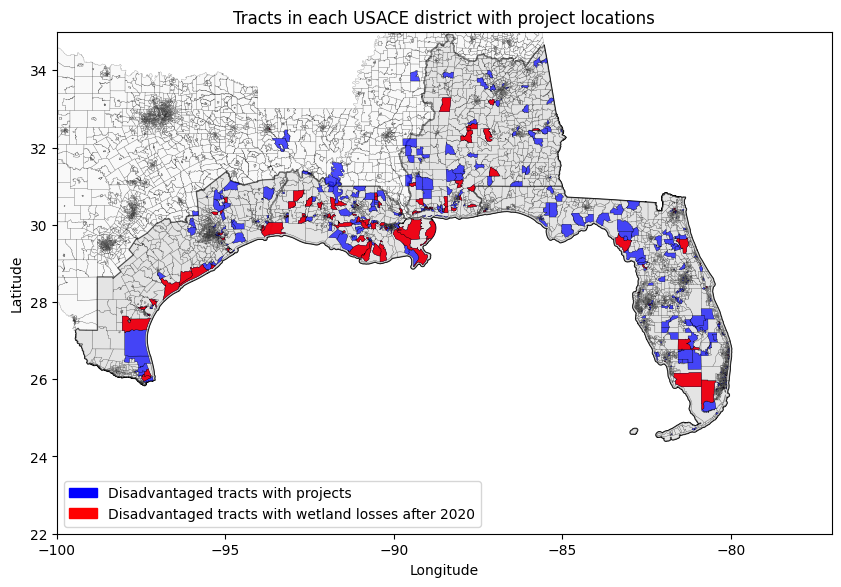

In [133]:
#join CEJST with project locations
cj_proj = cj.sjoin(spdf, predicate='intersects', how='inner')

# Group by GEOID10
cj_proj = cj_proj.groupby('GEOID10').agg(
    sum_wet_loss_20=pd.NamedAgg(column='wetland_loss_20', aggfunc='sum'),
    n_projects=pd.NamedAgg(column='noticeID', aggfunc=pd.Series.nunique)
).reset_index()

#merge with spatial dataframe and plot
cj_proj = cj.merge(cj_proj, left_on='GEOID10', right_on='GEOID10', how='inner')

# Assuming usace_shp, cj, and cj_proj are correctly prepared GeoDataFrames

fig, ax = plt.subplots(figsize=(10, 10))

# Base Layer: USACE districts
usace_shp.plot(ax=ax, color='lightgrey', edgecolor='black')

# All Tracts: Overlay cj with all tracts in a neutral color
cj.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5, linewidth=0.2)

# Tracts with Projects: Color in blue
cj_proj[(cj_proj['DA_score']>0)].plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, linewidth=0.2)

# disa
cj_proj[(cj_proj['sum_wet_loss_20'] > 0) & (cj_proj['DA_score']>0)].plot(ax=ax, color='red', edgecolor='black', alpha=0.9, linewidth=0.2)

# Set x-axis and y-axis limits
ax.set_xlim(left=-100, right=-77)
ax.set_ylim(top=35, bottom=22)

# Customize the plot
plt.title("Tracts in each USACE district with project locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)

# Create custom legend with square patches
blue_patch = mpatches.Patch(color='blue', label='Disadvantaged tracts with projects')
red_patch = mpatches.Patch(color='red', label='Disadvantaged tracts with wetland losses after 2020')
ax.legend(handles=[blue_patch, red_patch], loc='lower left')


# Show the plot
plt.show();



## Census ACS 2019 (Geography - Block Group)

Use tidycensus or Python Census API to get block-group level data from the latest ACS-5 (2019) for these states:

* Texas

* Louisiana

* Alabama

And join them to project locations in a similar manner. 

For now, 4 variables called:

- 'B02001_002E': 'white_pop', 
- 'B02001_003E': 'black_pop', 
- 'B02001_001E': 'tot_pop', 
- 'B19013_001E': 'median_inc'


This relies on the shapefiles of blockgroups in the 'spatial/' subfolder

- tl_2020_01_bg
- tl_2020_12_bg
- tl_2020_22_bg
- tl_2020_48_bg

In [463]:

def process_state(census_api_key, state_fips, shapefile_path, points=False, year=2019):
    """
    Processes data for a given state: fetches census data, reads shapefile, merges, and performs spatial join.

    Parameters:
    - census_api_key (str): API key for the Census data.
    - state_fips (str): FIPS code for the state.
    - shapefile_path (str): Path to the state's block group shapefile.
    - gdf (GeoDataFrame): GeoDataFrame for spatial join.
    - year (int): Year of the census data.

    Returns:
    - GeoDataFrame: The processed GeoDataFrame.
    """
    # Initialize Census with your API key
    census_api = Census(census_api_key)

    # Fetch data from Census API
    fields = ('NAME', 'B02001_001E', 'B02001_002E', 'B02001_003E', 'B19013_001E')
    data = census_api.acs5.state_county_blockgroup(fields, state_fips=state_fips, county_fips="*", blockgroup="*", year=year)
    census_df = pd.DataFrame(data)
    census_df.rename(columns={'B02001_002E': 'white_pop', 'B02001_003E': 'black_pop', 'B02001_001E': 'tot_pop', 'B19013_001E': 'median_inc'}, inplace=True)
    census_df['black_prop'] = census_df['black_pop'] / census_df['tot_pop']
    census_df['id'] = census_df['state'].astype(str) + census_df['county'].astype(str) + census_df['tract'].astype(str) + census_df['block group'].astype(str)

    # Read state shapefile
    shape_df = gpd.read_file(shapefile_path)
    shape_df['id'] = shape_df['GEOID']
    
    # Merge the dataframes
    merged_df = shape_df.merge(census_df, on='id', how='left')
    merged_df.crs = 'epsg:4326'

    # Perform spatial join
    if points==True:
        merged_df = gpd.sjoin(merged_df, gdf, predicate='intersects', how='left')
        merged_df['proj'] = np.where(merged_df.noticeID.isnull(), 0, 1)

    return merged_df

# Example usage:
api_key = ''

# Process data for each state
al_bg_df = process_state(api_key, '01', 'tl_2020_01_bg.zip', points=True)  # Alabama
la_bg_df = process_state(api_key, '22', 'tl_2020_22_bg.zip', points=True)  # Louisiana
tx_bg_df = process_state(api_key, '48', 'tl_2020_48_bg.zip', points=True)  # Texas


In [456]:



# Create a legend for 'CEJST score' (based on 'CC' column in 'cj')
cc_categories = cj['CC'].unique()
cc_patches = [mpatches.Patch(color=plt.cm.Blues(i / len(cc_categories)), label=category) 
              for i, category in enumerate(cc_categories)]
cc_legend = ax.legend(handles=cc_patches, title='CEJST Score', loc='upper right')

#subset
gdf_gv = gdf[(gdf.districtName=='Galveston District') & (gdf['lon'] < -90) &  (gdf['lat'] > 25)]

# merge with main/val for dates
gdf_gv =gdf_gv.merge(val_df[['noticeID','datePublished']], on = 'noticeID', how = 'left')

# Convert the entire column to datetime
gdf_gv['datepub'] = pd.to_datetime(gdf_gv['datePublished'], format = "mixed")

# Extract year for the entire column
gdf_gv['year'] = gdf_gv['datepub'].dt.year

# Define 'min_year' and 'max_year' based on the 'year' column in 'gdf_gv'
min_year = gdf_gv['year'].min()
max_year = gdf_gv['year'].max()

# Calculate year ranges for categorization
year_range = max_year - min_year
year_step = year_range // len(cc_categories) if len(cc_categories) > 1 else 1
year_categories = range(min_year, max_year + 1, year_step)

# Create patches for each year category
year_patches = [mpatches.Patch(color=plt.cm.Reds((year-min_year)/year_range), 
                               label=f"{year}-{min(year+year_step-1, max_year)}") 
                for year in year_categories]

# Plotting
fig, ax = plt.subplots(figsize=(16,14))

# Plot 'cj' with 'Blues' colormap
cj.plot('CC',
        alpha=0.7, 
        categorical=True,
        ax=ax,
        linewidth=0.1, 
        edgecolor='black',
        cmap='Blues',
        legend=True)

# Plot 'gdf_gv' with 'Reds' colormap
gdf.plot('year',
            markersize=1.1,
            alpha=0.7,
            categorical=True,
            cmap='Reds',
            ax=ax)

# Add the year legend to the plot
year_legend = ax.legend(handles=year_patches, title='Year of Project', loc='upper right')

# Re-adding the CEJST score legend as creating a new legend will remove the previous one
cc_legend = ax.get_legend()
ax.add_artist(cc_legend)

# Display the plot
plt.show()


NameError: name 'gdf_gv' is not defined

### Merge spatial df with

- Confirmed impact_type = 'loss'

- Project categories

In [464]:

# Define a function to prepare the DataFrame
def prepare_df(bg_df, wet_loss):
    # wetland impact df

    bg_df = bg_df.merge(wet_loss, on='noticeID', how='left')
    # embedding/project type df

    bg_df['oil_gas'] = bg_df['oil_gas'].fillna(0)
    
    bg_df['loss_impact'] = np.where(bg_df['impact_type'].isnull(), 0, 1)
    return bg_df

# Prepare TX and LA DataFrames
tx_bg_df = prepare_df(tx_bg_df, wet_emb)
la_bg_df = prepare_df(la_bg_df, wet_emb)
al_bg_df = prepare_df(al_bg_df, wet_emb)


#https://geospatial-usace.opendata.arcgis.com/datasets/70805e1a8fd74e42b0a9585088d6d151/explore?location=35.186439%2C-100.583229%2C4.52

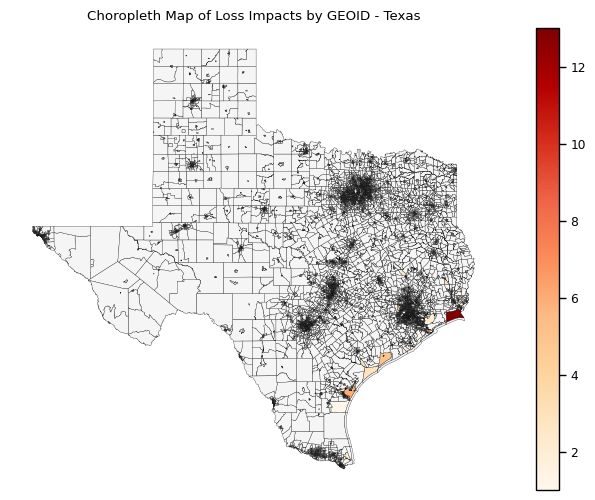

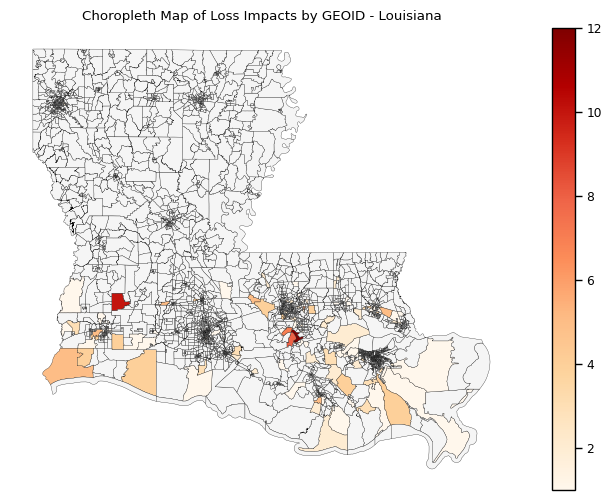

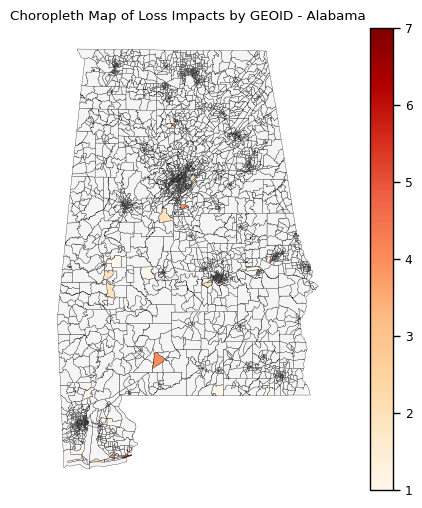

In [465]:
# Now, for each state, aggregate the data, convert to GeoDataFrame, and plot
def plot_state_loss_impact(bg_df, state_name):
    gdf_aggregated = bg_df.groupby(['GEOID', 'geometry'])['loss_impact'].sum().reset_index()
    gdf_aggregated = gpd.GeoDataFrame(gdf_aggregated, geometry='geometry')

    # Custom colormap: lightgrey for 0, and OrRd for others
    cmap = plt.cm.OrRd
    cmap.set_under('whitesmoke')

    # Plot the choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    gdf_aggregated.plot(column='loss_impact', ax=ax, legend=True, cmap=cmap, 
                        edgecolor='black', linewidth=0.2,
                        norm=mcolors.Normalize(vmin=1, vmax=max(gdf_aggregated['loss_impact'])))

    ax.set_title(f'Choropleth Map of Loss Impacts by GEOID - {state_name}')
    ax.set_axis_off()
    plt.show()

# Plot for Texas
plot_state_loss_impact(tx_bg_df, 'Texas')

# Plot for Louisiana
plot_state_loss_impact(la_bg_df, 'Louisiana')


# Plot for Alabama
plot_state_loss_impact(al_bg_df, 'Alabama')

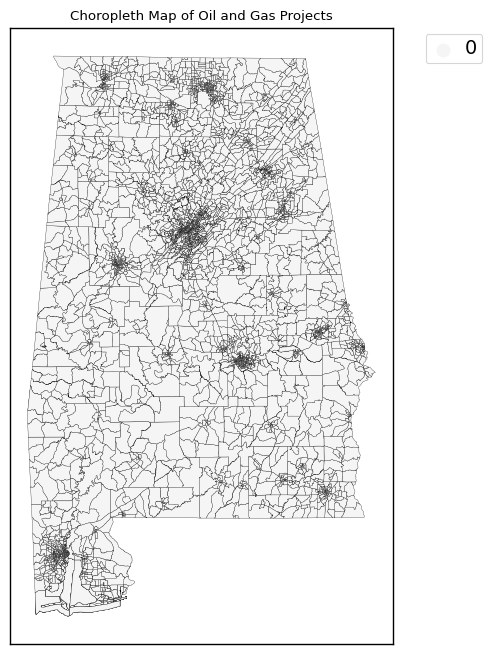

In [466]:

# Define a simple binary colormap
colors = ['whitesmoke', 'red']  # You can choose any two contrasting colors
cmap = mcolors.ListedColormap(colors)

# Plotting
fig, ax = plt.subplots(figsize=(10,8))


# Plotting the data
# 'column' should refer to the column in your DataFrame that you want to visualize
al_bg_df.plot(column='oil_gas', ax=ax, cmap=cmap, categorical=True,
                           edgecolor='black', linewidth=0.2, legend=True
                         #  missing_kwds={'color': 'lightgrey', 'label': 'No project detected'}
             )

ax.set_title('Choropleth Map of Oil and Gas Projects')

#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('Most common heating system type - Colorado', fontsize=20)
# Place the legend to the right of the figure
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25,1))
plt.setp(leg.get_texts(), fontsize=14)
# ax.set_title("My Plot", fontsize=18)
plt.show();


# plt.tight_layout()  # Adjust the layout


### Statistical relations

Data may not be normally distributed, consider non-parametric tests


C:\ProgramData\Anaconda3\envs\torchcu\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Text(0.0, 0.1497002073213699, '0.15')

Text(1.0, nan, 'nan')

Text(0, 0.5, 'Mean Median Income')

Text(0.5, 1.0, 'Mean Median Income by Group')

([0, 1],
 [Text(0, 0, 'Group 1 (Loss Impact = 0)'),
  Text(1, 0, 'Group 2 (Loss Impact > 0)')])

posx and posy should be finite values
posx and posy should be finite values


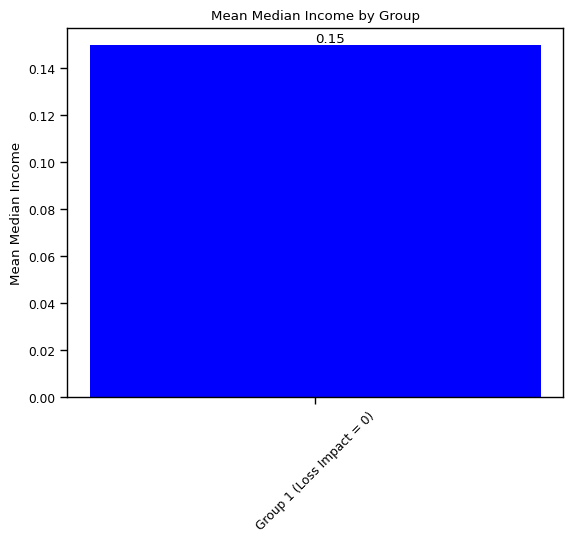

Text(0.5, -0.05, 'T-Test Result: p-value = nan')

In [480]:

# Remove NA values from the data and filter out non-positive median_inc

# group1 = al_bg_df[(al_bg_df['loss_impact'] == 0) & (al_bg_df.median_inc>0)]['median_inc'].dropna()
# group2 = al_bg_df[(al_bg_df['loss_impact'] > 0) & (al_bg_df.median_inc>0)]['median_inc'].dropna()

#black_prop
group1 = tx_bg_df[(tx_bg_df['oil_gas'] == 0) & (tx_bg_df.black_prop > 0)]['black_prop'].dropna()
group2 = tx_bg_df[(tx_bg_df['oil_gas'] > 0) & (tx_bg_df.black_prop > 0)]['black_prop'].dropna()

# Check for normality
if stats.shapiro(group1).pvalue > 0.05 and stats.shapiro(group2).pvalue > 0.05:
    # Data is normally distributed, proceed with t-test
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False) # Welch's t-test for unequal variances
    print("T-Statistic:", t_stat)
    print("P-Value:", p_value)
else:
    print("Data may not be normally distributed, consider non-parametric tests")



# Calculate means
mean_group1 = group1.mean()
mean_group2 = group2.mean()

# Conduct a t-test
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False) # Welch's t-test for unequal variances

# Create bar graph
labels = ['Group 1 (Loss Impact = 0)', 'Group 2 (Loss Impact > 0)']
means = [mean_group1, mean_group2]

fig, ax = plt.subplots()
bars = ax.bar(labels, means, color=['blue', 'orange'])

# Annotate each bar with the mean value
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # round to 2 decimal places


# Additional plot settings
ax.set_ylabel('Mean Median Income')
ax.set_title('Mean Median Income by Group')
plt.xticks(rotation=45)
plt.show();

# Add t-test result below the graph
if p_value < 0.001:
    result_text = f'T-Test Result: p-value < 0.001 ***'
elif p_value < 0.01:
    result_text = f'T-Test Result: p-value < 0.01 **'
elif p_value < 0.05:
    result_text = f'T-Test Result: p-value < 0.05 *'
else:
    result_text = f'T-Test Result: p-value = {p_value:.3f}'

fig.text(0.5, -0.05, result_text, ha='center')

#     # Perform a non-parametric test - Mann-Whitney U Test
# u_stat, p_value = stats.mannwhitneyu(group1.notna(), group2.notna(), alternative='two-sided')

# u_stat, p_value

## Regression


### Census - project

In [486]:

def run_regression(df, y_var, x_vars=None):
    """
    Runs a regression model on the specified dependent and independent variables.
    
    :param df: Pandas DataFrame containing the data.
    :param y_var: The name of the dependent variable column.
    :param x_vars: List of independent variable column names. If None, uses all other columns.
    :return: Summary of the regression model.
    """
    # Ensure the DataFrame contains the specified columns
    if y_var not in df.columns or (x_vars and not all(x in df.columns for x in x_vars)):
        raise ValueError("Specified columns not found in DataFrame")

    # Handle default case where x_vars are all columns except y_var
    if x_vars is None:
        x_vars = df.columns.drop(y_var)

    # Drop rows with NaN in the specified columns
    df = df[[y_var] + x_vars].dropna()

    # Add an intercept for the regression model
    df['intercept'] = 1

    # Define dependent and independent variables
    Y = df[y_var]
    X = df[x_vars + ['intercept']]

    # Create and fit the model
    model = sm.Logit(Y, X) if df[y_var].nunique() == 2 else sm.OLS(Y, X)
    result = model.fit()

    return result.summary()


In [490]:

# Example usage:
# df = your_dataframe_here
print(run_regression(al_bg_df, 'loss_impact', [ 'median_inc']))
print(run_regression(tx_bg_df, 'loss_impact', [ 'median_inc']))
print(run_regression(la_bg_df, 'loss_impact', [ 'median_inc']))


Optimization terminated successfully.
         Current function value: 0.059249
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            loss_impact   No. Observations:                 2566
Model:                          Logit   Df Residuals:                     2564
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                 0.01501
Time:                        19:44:16   Log-Likelihood:                -152.03
converged:                       True   LL-Null:                       -154.35
Covariance Type:            nonrobust   LLR p-value:                   0.03138
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
median_inc -2.072e-09   8.24e-10     -2.514      0.012   -3.69e-09   -4.57e-10
intercept     -4.6199      0.

### CEJST - project

In [491]:
cj = cj[['CC', 'proj']].dropna()

# txx.median_inc.isnull().sum() = 8556 empty
# Logistic Regression
cj['intercept'] = 1  # Adding an intercept
logit_model = sm.Logit(cj['proj'], cj[['intercept', 'CC']])
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.362334
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   proj   No. Observations:                 5743
Model:                          Logit   Df Residuals:                     5741
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:               1.885e-07
Time:                        19:45:08   Log-Likelihood:                -2080.9
converged:                       True   LL-Null:                       -2080.9
Covariance Type:            nonrobust   LLR p-value:                    0.9777
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0151      0.049    -40.913      0.000      -2.112      -1.919
CC             0.0007      0.